# TP6 - Clasificador de imágenes con red convolucional

Guarda una copia de este cuaderno en tu Google Drive para poder editarla y ejecutarla.

El propio cuaderno será tu informe del trabajo. Puedes añadir tantas secciones de código y de texto como consideres necesario para resolver todos los ejercicios propuestos y analizar los resultados obtenidos. Una vez hayas terminado, descarga el notebook en formato ipynb y súbelo a Moodle en la tarea habilitada para el TP6 con el nombre NIP_TP6_CNN.ipynb

Es **obligatorio** que se **guarden los resultados de la evaluación** de cada celda de código (para no tener que volver a ejecutarlas). Por defecto los notebooks estan configurados así (Edit→Notebook Settings → NUNCA actives: Omit code cell output when saving this notebook) 

El Notebook incluye código de ejemplo para definir y entrenar una red convolucional con el dataset MNIST. Recuerda que esta parte del trabajo se debe realizar con el dataset CIFAR 10.

Imports necesarios para ejecutar el trabajo

In [1]:
import keras
from keras.datasets import mnist, cifar10, cifar100
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping
import time
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()

Carga del dataset MNIST

Importante observar como la organización de los datos es diferente que en el caso del perceptrón para poder aplicar bien las convoluciones

In [3]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print(x_train.shape, x_train.shape, x_train.shape, x_train.shape)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.np_utils.to_categorical(y_test,  num_classes)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000, 28, 28) (60000, 28, 28) (60000, 28, 28)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
# MaxPooling2D 
# Reduce la muestra de la entrada a lo largo de sus dimensiones espaciales 
# (alto y ancho) tomando el valor máximo sobre una ventana de entrada 
# (de tamaño definido por pool_size) para cada canal de la entrada.
model.add(MaxPooling2D(pool_size=(2, 2))) # Capa de reagrupación maxima -> tamaño de la matriz (2x2)
model.add(Dropout(0.25)) 
model.add(Flatten()) # convierte nuestros resultados de imagen en forma de matriz en un vector para que pueda ser usado por las siguientes capas  
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

Preguntas a responder de la celda anterior:

1.    Incluye un dibujo de la arquitectura de la red programada en la celda anterior.

2.    Explica brevemente qué hace cada capa de la red.

1 -
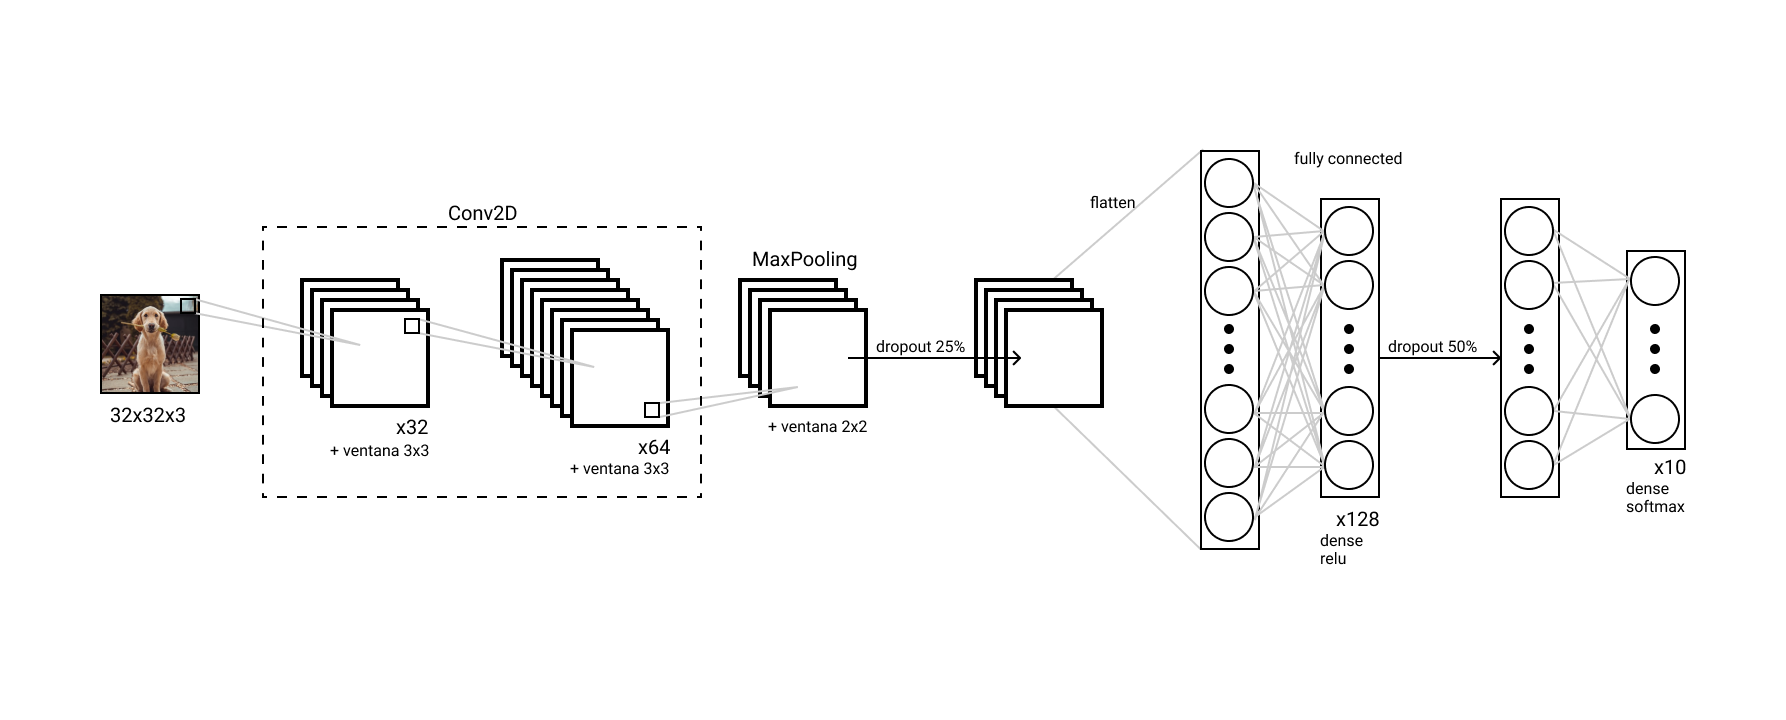
2 - capas:
- Conv2D: dada una entrada multicanal aplicará el filtro en todos los canales de color y sumará los resultados, produciendo el equivalente a una imagen de salida convolucionada monocromática.
- MaxPooling2D: **Reducen el peso** de la representación para así **agilizar** el proceso de **aprendizaje** de la red neuronal. 
Si tuviesemos una matriz de 4×4 y aplicamos una capa de Max Pooling, tendríamos que dividir la matriz en 4 cuadrantes y crear una nueva matriz con el valor más alto que haya dentro de cada uno de los resultados.
Estas capas a su vez nos aseguran que los patrones detectados en la capa convolucional se mantengan en la siguiente capa de la red.
- Dropout: Apaga un % de neuronas de forma repentina para evitar un sobreentrenamiento de la red.
- Flatten: Pasa los resultados obtenidos en las capas anteriores de matriz a vector para que pueda ser interpretado el resultado por el resto de capas.
conv2D(genera datos en forma de matriz) -> flatten(matriz->vector) -> dense(recibe datos en forma de vector).
- Dense - Relu: Para ajustar los pesos
- Dense - Softmax: Para poder clasificar las imagenes.

Epoch 1/12
469/469 [==============================] - 16s 15ms/step - loss: 0.2434 - accuracy: 0.9272
Epoch 2/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0839 - accuracy: 0.9754
Epoch 3/12
469/469 [==============================] - 7s 14ms/step - loss: 0.0613 - accuracy: 0.9817
Epoch 4/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0510 - accuracy: 0.9840
Epoch 5/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0430 - accuracy: 0.9868
Epoch 6/12
469/469 [==============================] - 7s 14ms/step - loss: 0.0374 - accuracy: 0.9884
Epoch 7/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0337 - accuracy: 0.9890
Epoch 8/12
469/469 [==============================] - 7s 14ms/step - loss: 0.0292 - accuracy: 0.9907
Epoch 9/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0265 - accuracy: 0.9913
Epoch 10/12
469/469 [==============================] - 7s 15ms/step - loss: 0.0258 - accur

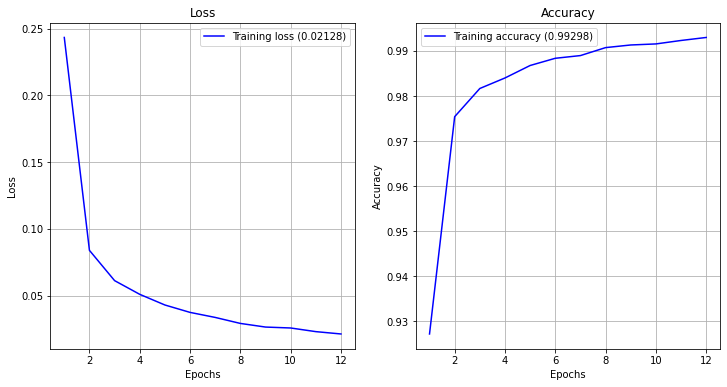

In [5]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Preguntas a responder de la celda anterior

¿Qué diferencias observas en el entrenamiento y en los resultados en comparación con las redes diseñadas en el otro Notebook?

El notebook que entregues deberá incluir:

1.   Modifica la carga de datos, y la configuración inicial de la red si lo ves necesario, para que cargue/utilice el dataset CIFAR10 en lugar de MNIST. Puedes pasar a blanco y negro las imágenes, o hacer que la red trabaje con imagenes en color (n x m x 3), y siempre, normalizar los valores (atributos con valores entre 0 y 1).
2.   Entrena un perceptrón multi-capa y evalúa los resultados que obtiene para CIFAR10. Compara estos resultados con los obtenidos en el dataset anterior (MNIST)
3.   Entrena una red convolucional y evalúa los resultados que obtiene con CIFAR10. Compara estos resultados con los obtenidos para el perceptrón.
4.   Opcional: Repite el último paso, entrenar la red convolucional, utilizando el dataset CIFAR 100, con 100 clases diferentes. En este caso, recuerda asegurarte que el Colab está utilizando una configuración con GPU.

Carga del dataset CIFAR10

In [70]:
batch_size = 128
num_classes = 10
epochs = 12

# labels of the cifar cifar10 dataset
classNames = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # https://keras.io/api/datasets/cifar10/
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape  == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape  == (10000, 1)


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.np_utils.to_categorical(y_test,  num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


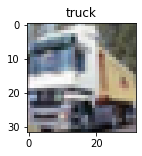

In [71]:
def plot_sample(X, y, index):
  plt.figure(figsize=(32, 2))
  plt.imshow(X[index])
  plt.title(classNames[list(y[index]).index(1)])

plot_sample(x_train, y_train, 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_5 (Dense)             (None, 100)               307300    
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 10)                1010      
                                                                 
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
352/352 [==============================] - 3s 6ms/step - loss: 1.9108 - accuracy: 0.3130 - val_loss: 1.8658 - val_accuracy: 0.3446
Epoch 2/12
352/352 [==================

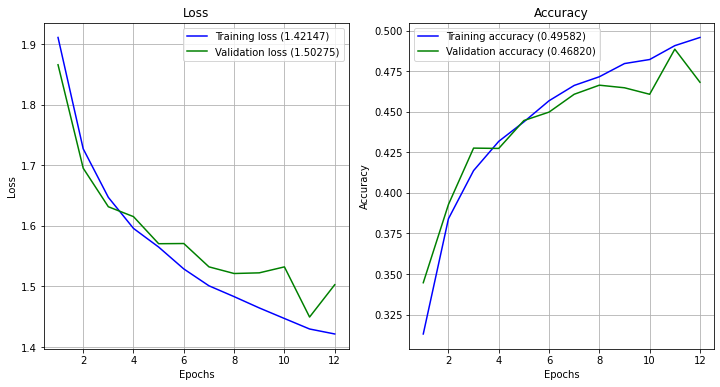

In [10]:
# Función para parar cuando ya no mejora el error en los datos de validacion
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# Definicion del perceptrón multicapa
modelo = Sequential()
modelo.add(Flatten(input_shape=(32, 32, 3)))
modelo.add(Dense(100, activation="relu"))
modelo.add(Dense(100, activation="relu"))
modelo.add(Dense(10, activation="softmax"))
modelo.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
modelo.summary()

# t0 = time.perf_counter()
history = modelo.fit(
  x_train, y_train, batch_size=128, epochs=epochs, validation_split=0.1,
  callbacks=[earlystop], verbose=True
)
# train_time = time.perf_counter() - t0
# print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
plot_history(history)

Al ejecutar el perceptron multicapa para el dataset de cifar10 se puede ver como hay una serie de picos en la gráfica de accuracy que indican como los nuevos valores no son correctamete reconocidos/clasificados, sin embargo, en "798095_TP6_MLP" se podia observar como las funciones de accuracy eran muy similares indicando que se reconocian bastante bien los nuevos datos, esto se puede deber a que como en el dataset de cifar 10 hay más cosas de analizar, el perceptron multicapa no es capaz de aislar todos los patrones de forma correcta para luego poder identificarlos es por eso que para el caso de cifar10 es mejor usar una red convolucional ya que al esta utilizar un filtro para analizar las imagenes introduzidas como inputs sera capaz de generar mas informacion para posteriormente ser capaz de interpretarla y reconocer las imagenes de cifar10.
Abajo dejo una imagen de como funcionaría un filtro en una red convolucional.


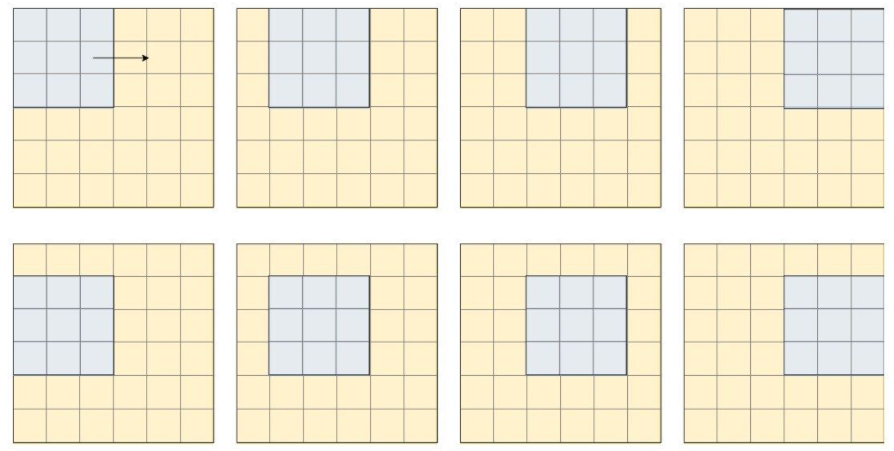

In [11]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_3 (Flatten)         (None, 12544)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               1605760   
                                                      

Epoch 1/12
352/352 [==============================] - 7s 18ms/step - loss: 1.6824 - accuracy: 0.3869 - val_loss: 1.2891 - val_accuracy: 0.5494
Epoch 2/12
352/352 [==============================] - 6s 17ms/step - loss: 1.3476 - accuracy: 0.5149 - val_loss: 1.1575 - val_accuracy: 0.5856
Epoch 3/12
352/352 [==============================] - 6s 17ms/step - loss: 1.2107 - accuracy: 0.5693 - val_loss: 1.0203 - val_accuracy: 0.6378
Epoch 4/12
352/352 [==============================] - 6s 17ms/step - loss: 1.1127 - accuracy: 0.6045 - val_loss: 0.9631 - val_accuracy: 0.6642
Epoch 5/12
352/352 [==============================] - 6s 17ms/step - loss: 1.0471 - accuracy: 0.6294 - val_loss: 0.9359 - val_accuracy: 0.6758
Epoch 6/12
352/352 [==============================] - 6s 17ms/step - loss: 0.9974 - accuracy: 0.6470 - val_loss: 0.9033 - val_accuracy: 0.6890
Epoch 7/12
352/352 [==============================] - 6s 18ms/step - loss: 0.9537 - accuracy: 0.6607 - val_loss: 0.9092 - val_accuracy: 0.6850

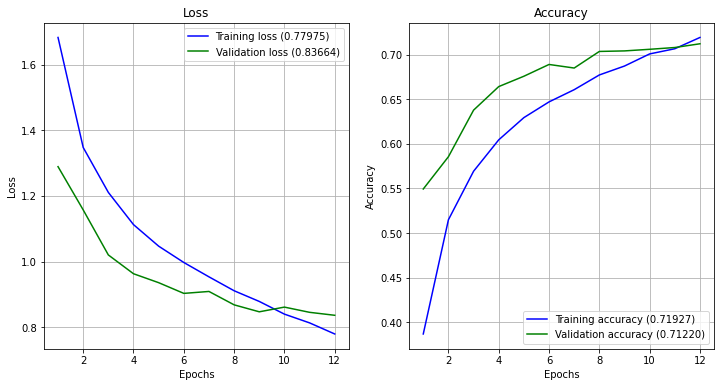

In [12]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,
          callbacks=[earlystop], verbose=True
)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Como se puede apreciar, en comparación con el perceptron multicapa, la red convolucional ha mostrado un mejor rendimiento para el dataset de cifar10, mostrando una accuracy bastante mayor (+0.2 aprox) a la del perceptron , además, la función de validacion para la accuracy presenta picos menos bruscos que la del perceptron indicando asi un mejor funcionamiento para nuevos datos.

Prediccion para la imagen con id: 9892
key:  dog        probability:  0.6116    
key:  horse      probability:  0.1951    
key:  cat        probability:  0.1349    
key:  deer       probability:  0.0351    
key:  bird       probability:  0.0227    
key:  frog       probability:  0.0006    
key:  airplane   probability:  0.0000    
key:  truck      probability:  0.0000    
key:  automobile probability:  0.0000    
key:  ship       probability:  0.0000    


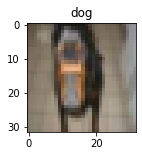

In [15]:
import random

def getPrediction(id):
  print(f"Prediccion para la imagen con id: {id}")
  plot_sample(x_test, y_test, id)

  predictions = model.predict( np.array([x_test[id]]) )

  cremallera = zip(classNames, predictions[0])
  predicciones = dict(cremallera)
  predicciones = dict(sorted(predicciones.items(), key= lambda x: x[1], reverse=True))
  
  for key in predicciones:
    print("key: ", f"{key}".ljust(10), "probability: ", f"{predicciones[key]:.4f}".ljust(10))

getPrediction(random.randint(0, len(x_test)))

Prediccion para la imagen con id: 200
key:  dog        probability:  0.5365    
key:  cat        probability:  0.3770    
key:  horse      probability:  0.0417    
key:  bird       probability:  0.0384    
key:  deer       probability:  0.0037    
key:  frog       probability:  0.0025    
key:  airplane   probability:  0.0001    
key:  truck      probability:  0.0001    
key:  automobile probability:  0.0000    
key:  ship       probability:  0.0000    


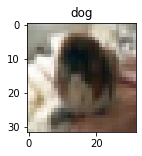

In [16]:
# ejemplo de imagen detectada erroneamente: es un pajaro y dice que es un perro
getPrediction(200)

In [72]:
batch_size = 128
num_classes = 100
epochs = 12

# labels of the cifar cifar100 dataset
classNames = ["apple", "aquarium_fish", "baby", "bear", "beaver", "bed", "bee", "beetle", "bicycle", "bottle", "bowl", "boy", "bridge", "bus", "butterfly", "camel", "can", "castle", "caterpillar", "cattle", "chair", "chimpanzee", "clock", "cloud", "cockroach", "couch", "crab", "crocodile", "cup", "dinosaur", "dolphin", "elephant", "flatfish", "forest", "fox", "girl", "hamster", "house", "kangaroo", "keyboard", "lamp", "lawn_mower", "leopard", "lion", "lizard", "lobster", "man", "maple_tree", "motorcycle", "mountain", "mouse", "mushroom", "oak_tree", "orange", "orchid", "otter", "palm_tree", "pear", "pickup_truck", "pine_tree", "plain", "plate", "poppy", "porcupine", "possum", "rabbit", "raccoon", "ray", "road", "rocket", "rose", "sea", "seal", "shark", "shrew", "skunk", "skyscraper", "snail", "snake", "spider", "squirrel", "streetcar", "sunflower", "sweet_pepper", "table", "tank", "telephone", "television", "tiger", "tractor", "train", "trout", "tulip", "turtle", "wardrobe", "whale", "willow_tree", "wolf", "woman", "worm"]

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data() # https://keras.io/api/datasets/cifar100/
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.np_utils.to_categorical(y_test,  num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_5 (Flatten)         (None, 12544)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               1605760   
                                                      

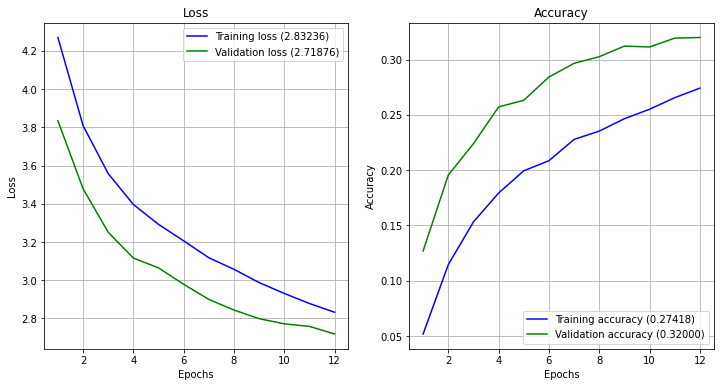

In [20]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,
          callbacks=[earlystop], verbose=True
)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Prediccion para la imagen con id: 5324
key:  lamp       probability:  0.1854    
key:  telephone  probability:  0.1107    
key:  bottle     probability:  0.0793    
key:  clock      probability:  0.0586    
key:  can        probability:  0.0546    
key:  cup        probability:  0.0403    
key:  plate      probability:  0.0249    
key:  mouse      probability:  0.0246    
key:  lawn_mower probability:  0.0232    
key:  rocket     probability:  0.0223    
key:  worm       probability:  0.0217    
key:  dinosaur   probability:  0.0193    
key:  bowl       probability:  0.0187    
key:  girl       probability:  0.0173    
key:  cockroach  probability:  0.0155    
key:  boy        probability:  0.0155    
key:  woman      probability:  0.0134    
key:  seal       probability:  0.0129    
key:  raccoon    probability:  0.0129    
key:  keyboard   probability:  0.0123    
key:  baby       probability:  0.0112    
key:  bear       probability:  0.0111    
key:  television probability:  0.0105

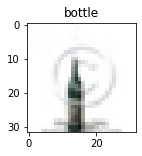

In [85]:
getPrediction(5324)